In [1]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import re
import datetime
import time

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
init_notebook_mode(connected=True)

import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

import progressbar

import seaborn as sns

In [2]:
######## Parameters #########

with open('/Users/chengdaoyang/Documents/Personal/Token/mapbox') as fp:
    mapbox_access_token = fp.readline()


######## Parameters #########

In [3]:

######## Function Start ########


def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])


def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max



def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])
    
    
    

    
def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)

    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))

    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]

        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)

        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])
    
######## Function End ########

loading data

In [4]:
## 自己的 geopandas + plotly 去 centroid

taxi_zone_map = gpd.read_file('Matrix/taxi_zones/taxi_zones.shp')
taxi_zone_map_geo = taxi_zone_map.to_crs(epsg=4326)  # EPSG 4326 = WGS84 = https://epsg.io/4326
print(taxi_zone_map.iloc[0].geometry.centroid.y, taxi_zone_map_geo.iloc[0].geometry.centroid.y)

191376.74953083202 40.691839452780165


In [14]:
incomplete_zone_distance_matrix = pd.read_csv('./Data/zone_distance_matrix.csv', index_col=0)
zone_distance_matrix = pd.read_csv('./Data/full_zone_distance_matrix.csv', index_col=0)
zone_distance_matrix = zone_distance_matrix.iloc[1:,1:]
zone_distance_matrix.shape

(264, 264)

In [15]:
freq = pd.DataFrame(arr_time_PU_DO.sum(axis=0))
mask = (freq.index.get_level_values(0)==1) 

freq[(freq.index.get_level_values(0)==1) ]

data = [go.Bar(y=freq[i],
              name=f'pickup_zone{i}')
       for i in range(100,109)]  

layout = go.Layout(title=('Drop of freqency '
                          +'of pickup zone'))
fig = go.Figure(data, layout)
iplot(fig)

NameError: name 'arr_time_PU_DO' is not defined

In [16]:
## 网上找的  
##https://chih-ling-hsu.github.io/2018/05/14/NYC
sf = shapefile.Reader("Data/taxi_zones/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()

,LocationID,OBJECTID,Shape_Area,Shape_Leng,borough,zone,longitude,latitude
0,1,1,0.000782,0.116357,EWR,Newark Airport,9.366817e+05,190522.130278
1,2,2,0.004866,0.433470,Queens,Jamaica Bay,1.033536e+06,161853.982300
2,3,3,0.000314,0.084341,Bronx,Allerton/Pelham Gardens,1.027136e+06,254730.010849
3,4,4,0.000112,0.043567,Manhattan,Alphabet City,9.904240e+05,203100.040432
4,5,5,0.000498,0.092146,Staten Island,Arden Heights,9.321332e+05,139954.541936


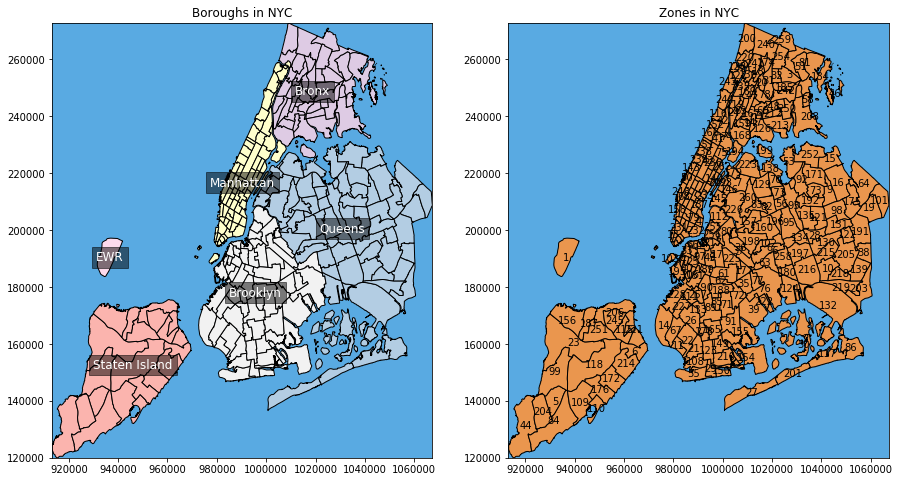

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)

In [28]:
data = [
    go.Scattermapbox(
        lon=[str(taxi_zone_map_geo['geometry'][i].centroid.xy[0][0])],
        lat=[str(taxi_zone_map_geo['geometry'][i].centroid.xy[1][0])],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14
        ),
        text=[i],
    )
    for i in range(taxi_zone_map_geo.shape[0]      -      200)]


layout = go.Layout(
    width=1000,
    height=600,
    autosize=True,
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lon=taxi_zone_map_geo['geometry'][28].centroid.xy[0][0],
            lat=taxi_zone_map_geo['geometry'][28].centroid.xy[1][0]
        ),
        pitch=0,
        zoom=8
    ),
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='Montreal Mapbox')

In [18]:
G=nx.Graph()

for i in range(taxi_zone_map.shape[0]):
    G.add_node(i, pos=(taxi_zone_map_geo['geometry'][i].centroid.xy[0][0],
                      taxi_zone_map_geo['geometry'][i].centroid.xy[1][0]))

In [19]:
rows = taxi_zone_map.shape[0]
cols = taxi_zone_map.shape[1]

for i in range(rows):
    for j in range(cols):
        if incomplete_zone_distance_matrix.iloc[i,j] == incomplete_zone_distance_matrix.iloc[i,j]:
            G.add_edge(i,j, weight=incomplete_zone_distance_matrix.iloc[i,j])


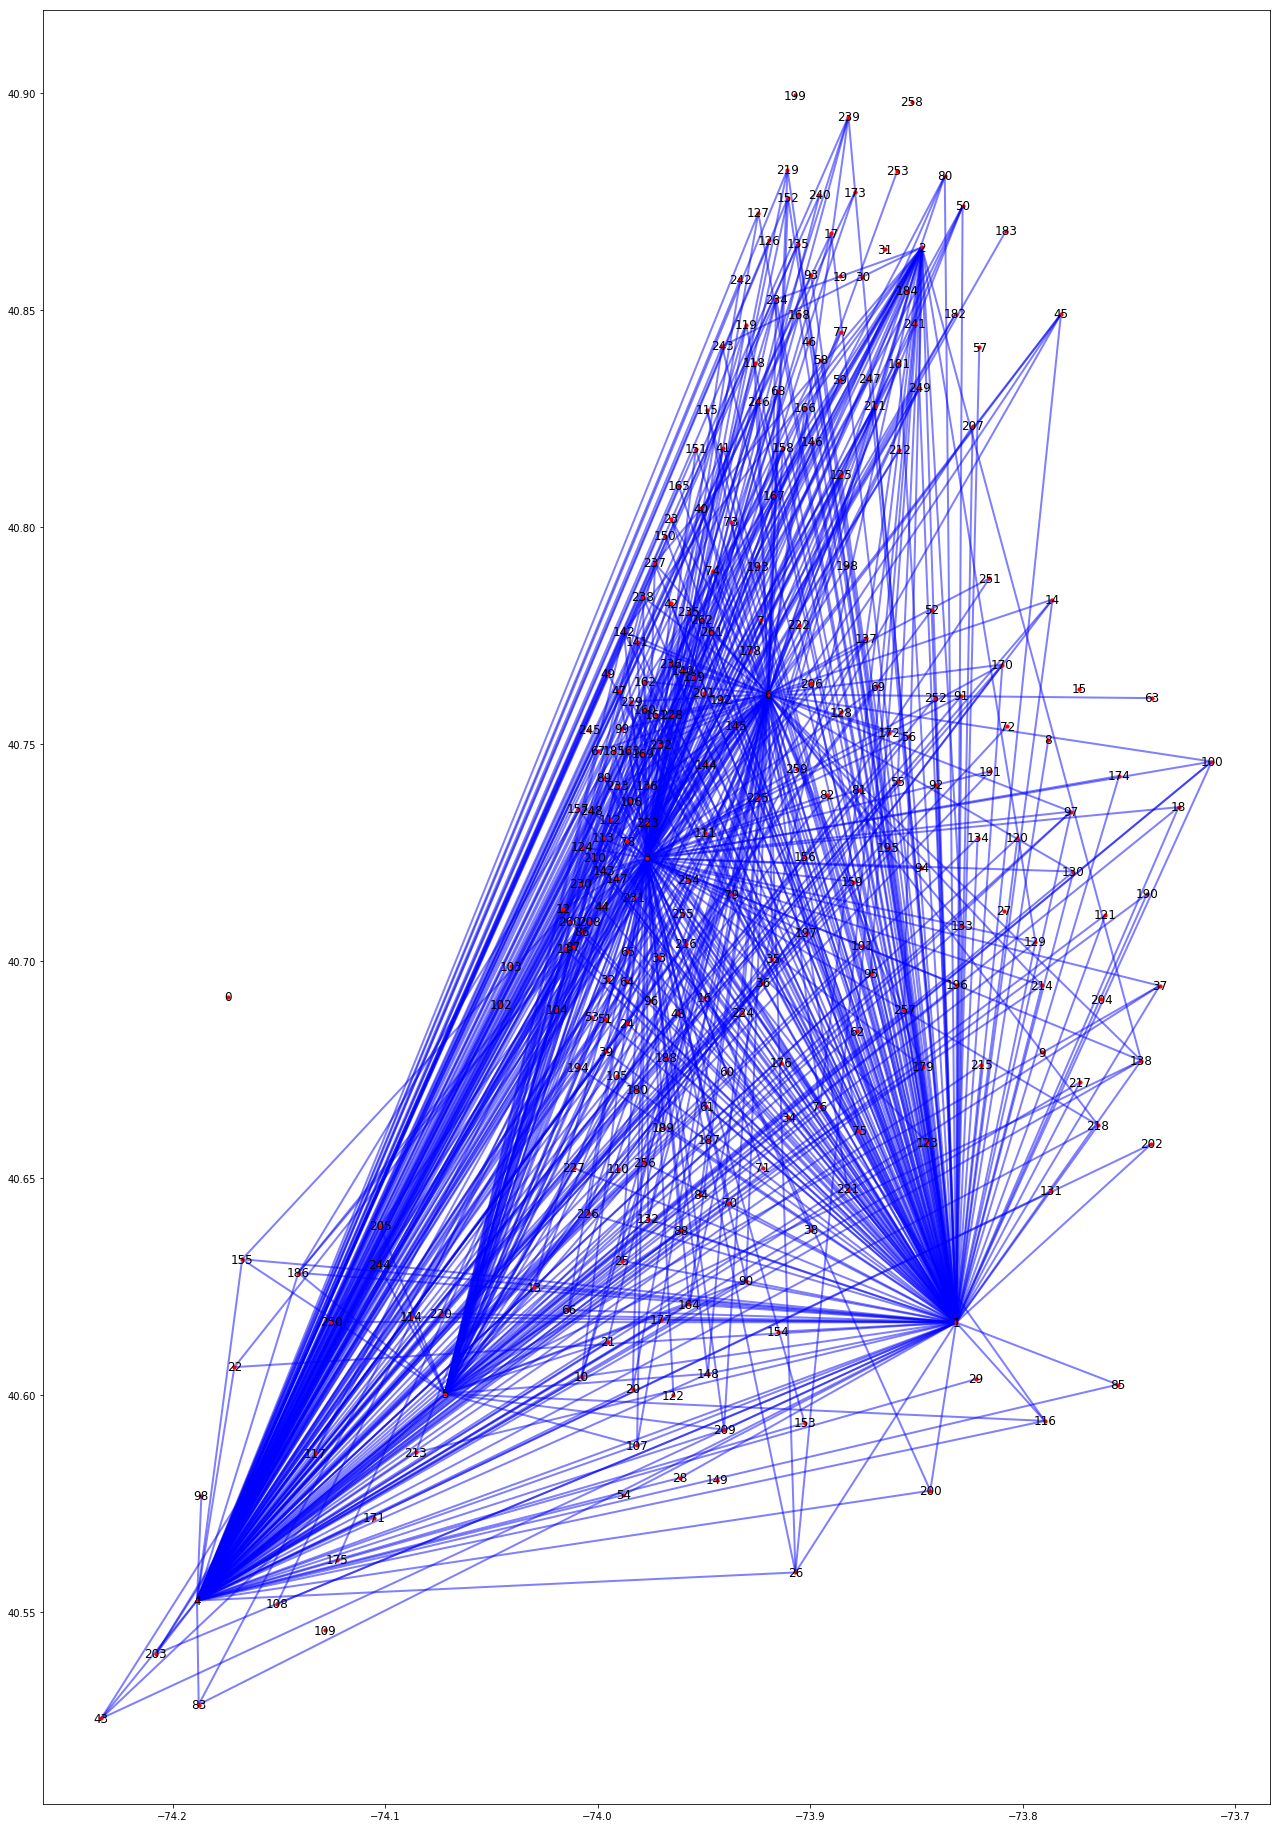

In [12]:
plt.figure(1,figsize=(22,33))

pos = nx.get_node_attributes(G, 'pos')
# pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos,node_size=10,font_size=7,width=8,alpha=1.0)
nx.draw_networkx_edges(G,pos,font_size=7,edgelist=G.edges(),
                       width=2,alpha=0.5,edge_color='b',edge_size=2)


nx.draw_networkx_labels(G, pos)
# nx.draw(G, pos, with_labels=True, node_size=0)
plt.axis('on')
plt.show()

In [13]:

for i in range(rows):
    for j in range(cols):
        if zone_distance_matrix.iloc[i,j] == zone_distance_matrix.iloc[i,j]:
            G.add_edge(i,j, weight=zone_distance_matrix.iloc[i,j])

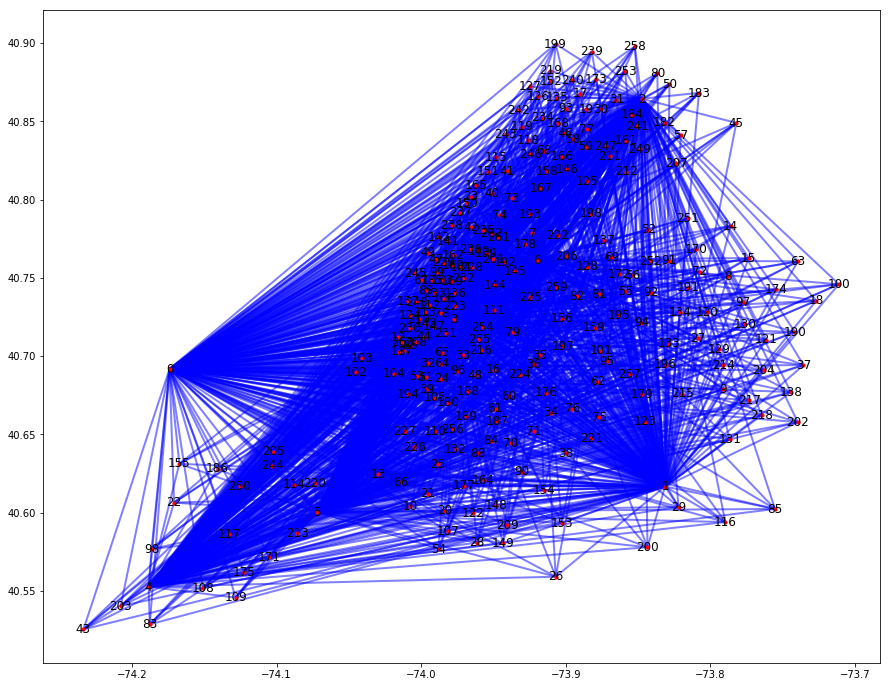

In [14]:
plt.figure(1,figsize=(15,12))

pos = nx.get_node_attributes(G, 'pos')
# pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos,node_size=10,font_size=7,width=8,alpha=1.0)
nx.draw_networkx_edges(G,pos,font_size=7,edgelist=G.edges(),
                       width=2,alpha=0.5,edge_color='b',edge_size=2)


nx.draw_networkx_labels(G, pos)
# nx.draw(G, pos, with_labels=True, node_size=0)
plt.axis('on')
plt.show()

In [ ]:
figure(num=None, figsize=(15, 13), dpi=80, facecolor='w', edgecolor='k')
m = Basemap(
        projection='merc',
        llcrnrlon=-74.5,
        llcrnrlat=40.3,
        urcrnrlon=-73.4,
        urcrnrlat=41,
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)

G=nx.Graph()

for i in range(42):
    G.add_node(i, pos=m(taxi_zone_map_geo['geometry'][i].centroid.xy[0][0],
                      taxi_zone_map_geo['geometry'][i].centroid.xy[1][0]))


rows = taxi_zone_map.shape[0]
cols = taxi_zone_map.shape[1]

# for i in range(42):
#     for j in range(42):
#         if incomplete_zone_distance_matrix.iloc[i,j] == incomplete_zone_distance_matrix.iloc[i,j]:
#             G.add_edge(i,j, weight=incomplete_zone_distance_matrix.iloc[i,j])
            
for i in range(42):
    for j in range(42):
        if zone_distance_matrix.iloc[i,j] == zone_distance_matrix.iloc[i,j]:
            G.add_edge(i,j, weight=zone_distance_matrix.iloc[i,j])
pos = nx.get_node_attributes(G, 'pos')

# draw
nx.draw_networkx(G,pos,node_size=200,node_color='blue')

# Now draw the map
m.drawcountries()
m.drawstates()
m.drawcoastlines()
m.drawmapboundary()
m.bluemarble()

plt.title('How to get from point a to point b')
plt.show()

In [20]:
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.node[edge[0]]['pos']
    x1, y1 = G.node[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in G.nodes():
    x, y = G.node[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

In [22]:
edge_trace

Scatter({
    'hoverinfo': 'none',
    'line': {'color': '#888', 'width': 0.5},
    'mode': 'lines',
    'x': [-73.83129992980908, -73.83129992980908, None, ..., -73.91969574327597,
          -73.9510113097146, None],
    'y': [40.61675353530702, 40.61675353530702, None, ..., 40.7615008311271,
          40.77877412668164, None]
})

In [ ]:
go.Scattermapbox(
        lon=[str(taxi_zone_map_geo['geometry'][i].centroid.xy[0][0])],
        lat=[str(taxi_zone_map_geo['geometry'][i].centroid.xy[1][0])],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14
        ),
        text=[i],
    )
    for i in range(taxi_zone_map_geo.shape[0]      -      200)]

In [29]:
edge_trace

Scatter({
    'hoverinfo': 'none',
    'line': {'color': '#888', 'width': 0.5},
    'mode': 'lines',
    'x': [-73.83129992980908, -73.83129992980908, None, ..., -73.91969574327597,
          -73.9510113097146, None],
    'y': [40.61675353530702, 40.61675353530702, None, ..., 40.7615008311271,
          40.77877412668164, None]
})

In [21]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

iplot(fig, filename='networkx')

In [ ]:
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')


In [48]:
df_airports = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_airport_traffic.csv')
df_airports.head()

df_flight_paths = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_aa_flight_paths.csv')
df_flight_paths.head()

airports = [go.Scattergeo(
    locationmode = 'USA-states',
    lon=[str(taxi_zone_map_geo['geometry'][i].centroid.xy[0][0]) for i in range(taxi_zone_map_geo.shape[0]      -      200)],
    lat=[str(taxi_zone_map_geo['geometry'][i].centroid.xy[1][0]) for i in range(taxi_zone_map_geo.shape[0]      -      200)],
       
    hoverinfo = 'text',
    text = df_airports['airport'],
    mode = 'markers',
    marker = go.scattergeo.Marker(
        size = 2,
        color = 'rgb(255, 0, 0)',
        line = go.scattergeo.marker.Line(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    ))]

flight_paths = []
for i,j in G.edges():
    flight_paths.append(
        go.Scattergeo(
            locationmode = 'USA-states',
            lon = [taxi_zone_map_geo['geometry'][i].centroid.xy[0][0], taxi_zone_map_geo['geometry'][j].centroid.xy[0][0]],
            lat = [taxi_zone_map_geo['geometry'][i].centroid.xy[1][0], taxi_zone_map_geo['geometry'][j].centroid.xy[1][0]],
            mode = 'lines',
            line = go.scattergeo.Line(
                width = 1,
                color = 'red',
            ),
            opacity = float(df_flight_paths['cnt'][i]) / float(df_flight_paths['cnt'].max()),
        )
    )

layout = go.Layout(
    title = go.layout.Title(
        text = 'Feb. 2011 American Airline flight paths<br>(Hover for airport names)'
    ),
    showlegend = False,
    geo = go.layout.Geo(
        scope = 'north america',
        projection = go.layout.geo.Projection(type = 'azimuthal equal area'),
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
)

fig = go.Figure(data = flight_paths + airports, layout = layout)
iplot(fig, filename = 'd3-flight-paths')

In [46]:
def Randomized_Greedy_Algorithm(start_zone, randomness=3):

    '''Randomized Greedy algorithm search the at each states
    the minimized moving & wait time zone. with some randomness
    return a path, total_trip_time & total_waste
    
    Args:
        start_zone(int): a int represent TLC zones as
        a starting zone of the alg
        
        randomness(float): between 0 and 1 to given some 
        randomness like entropy function, but with 1 the most
        random and 0 == Greedy Alg
        
    Retrun:
        result_list(list): path of the taxi in a day
        
        total_trip_time(float): total time that taxi is making 
            money i.e. serving customers
        
        total_waste_time(float): time moving and waiting

        '''
    
    
    ## loading data
    matrix_PU_time= pd.read_csv('./Matrix/matrix_PU_time.csv',index_col=0)
    matrix_PU_time.columns =matrix_PU_time.columns.astype(float)

    matrix_PU_time.fillna(value=8*60, inplace=True)
    matrix_PU_wait_time = matrix_PU_time.set_index(matrix_PU_time.index.astype(int)).sort_index()
    
    matrix_zone_distance = pd.read_csv('./Matrix/full_zone_distance_matrix.csv',index_col=0)
    matrix_zone_distance.columns =matrix_zone_distance.columns.astype(int)
    matrix_zone_distance.index = matrix_zone_distance.index + 1
    temp_index = matrix_zone_distance.index
    matrix_zone_distance = matrix_zone_distance.T
    matrix_zone_distance.index = temp_index
    ind_dis = set(matrix_zone_distance.iloc[146].index)
    ind_wait_time = set(matrix_PU_wait_time[0].index)
    redundant_zones = list(ind_dis.difference(ind_wait_time))
    matrix_zone_distance = matrix_zone_distance.drop(redundant_zones, axis=1).drop(list(map(int, redundant_zones)))
    matrix_zone_distance[matrix_zone_distance.isna().any(axis=1)]
    
    matrix_prob_PU_DO_t0 = pd.read_csv('./Matrix/matrix_prob_PU_DO_t0.csv', index_col=0)
    matrix_prob_PU_DO_t0.index = matrix_prob_PU_DO_t0.index.astype(int)
    matrix_prob_PU_DO_t0.columns = matrix_prob_PU_DO_t0.columns.astype(int)
    top_dropoff_zone_t0 = pd.DataFrame(matrix_prob_PU_DO_t0.idxmax(axis=1))
    
    random_number = int(-0.2/(.000000000000001-(randomness+0.000001)) +0.812)
    if random_number > 20:
        random_number = 20
    elif random_number < 1:
        random_number = 1
    result_path = list() # path with zone as node
    total_trip_time = 0 # total time that are making $
    total_waste_time = 0 # total time waste in move & wait
    total_time = 24*60 # time of a day
    temp_zone = start_zone # set current zone to starting zone
    
    while total_time >= 0:
        result_path.append(temp_zone)
        # compute highest pro drop off zone
        dropoff_zone = top_dropoff_zone_t0.iloc[temp_zone][0]
        result_path.append(dropoff_zone)
        
        # compute trip_time between pickup and dropoff zone
        dropoff_trip_time =  matrix_zone_distance.iloc[temp_zone,dropoff_zone]
        total_trip_time = total_trip_time + dropoff_trip_time # add trip time to total
        total_time = total_time - dropoff_trip_time # subtract the trip time from the day
        
        # compute moving_time to other zones and the wait time in other zones
        trip_wait_time_table = pd.DataFrame(np.array(matrix_zone_distance.iloc[260])
                                            + np.array(matrix_PU_wait_time[0])).sort_values(by=0)

        # looking for the min 
        trip_wait_time_table = trip_wait_time_table[:20].sample(random_number)
        local_min_cost_zone = trip_wait_time_table.idxmin()[0]
        local_min_cost_time = trip_wait_time_table.min()[0]
        
        # update current(temp) zone, total_waste time on moving and waiting, and day
        temp_zone = local_min_cost_zone
        total_waste_time = total_waste_time + local_min_cost_time
        total_time = total_time - local_min_cost_time
        
    return result_path, total_trip_time, total_waste_time

In [5]:

from taxi_algorithm import Randomized_Greedy_Algorithm

In [11]:

path = Randomized_Greedy_Algorithm(50, 0)[0]

In [12]:
G=nx.Graph()

for i in range(taxi_zone_map.shape[0]):
    G.add_node(i, pos=(taxi_zone_map_geo['geometry'][i].centroid.xy[0][0],
                      taxi_zone_map_geo['geometry'][i].centroid.xy[1][0]))
G.add_path(path)



map_path = []
for u in path:
    map_path.append(list(G.node[u]['pos']))
    
the_geojson_type_dict = {
    "type": "LineString", 
    "coordinates": [map_path
    ]
}


In [14]:
zones = [
    go.Scattermapbox(
        lon=[str(taxi_zone_map_geo['geometry'][i].centroid.xy[0][0]) for i in range(taxi_zone_map_geo.shape[0])],
        lat=[str(taxi_zone_map_geo['geometry'][i].centroid.xy[1][0]) for i in range(taxi_zone_map_geo.shape[0])],
#         lon = [str(taxi_zone_map_geo['geometry'][i].centroid.xy[0][0]) for i in path ],
#         lat = [str(taxi_zone_map_geo['geometry'][i].centroid.xy[1][0]) for i in path ],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=4
        ),
        text=[i for i in taxi_zone_map_geo.index],
    )
]
path_zones = [
    go.Scattermapbox(
#         lon=[str(taxi_zone_map_geo['geometry'][i].centroid.xy[0][0]) for i in range(taxi_zone_map_geo.shape[0])],
#         lat=[str(taxi_zone_map_geo['geometry'][i].centroid.xy[1][0]) for i in range(taxi_zone_map_geo.shape[0])],
        lon = [str(taxi_zone_map_geo['geometry'][i].centroid.xy[0][0]) for i in path ],
        lat = [str(taxi_zone_map_geo['geometry'][i].centroid.xy[1][0]) for i in path ],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14
        ),
        text=[f'zone{i}' for i in path],
    )
]


the_geojson_type_dict = {
    "type": "LineString", 
    "coordinates": map_path
}



layers=[dict(sourcetype = 'geojson',
         source =the_geojson_type_dict,
         color='rgb(5,170,35)',
         type = 'line',
         line=dict(width=4.5),
   )
     ]  
     
layout = dict(
title='path for yellow cab via greedy algorithm',
autosize=False,
width=1000,
height=800,
hovermode='closest',

mapbox=dict(
    accesstoken=mapbox_access_token,
    layers=layers,
    bearing=0,
    pitch=0,
    center=go.layout.mapbox.Center(
            lon=-73.97,
            lat=40.71
        ),
    zoom=9.44,
    #style='light'
)
)

fig = go.Figure(data=zones + path_zones, layout=layout)
iplot(fig, filename='NYC_path')


In [10]:
mapbox=dict(
    accesstoken=mapbox_access_token,
    layers=layers,
    bearing=0,
    center=dict(
        lat=45.778408,
        lon=3.085790
    ),
    pitch=0,
    zoom=4.75,
    #style='light'
)

mapbox

{'accesstoken': 'pk.eyJ1IjoiYmVpaGFpc2FucmVuIiwiYSI6ImNqdXk2bGNuNjB1cHQ0M2tpcjkwaW1ucDgifQ.RZh7qDmWk07ut0nDTqzqoA\n',
 'layers': [{'sourcetype': 'geojson',
   'source': {'type': 'LineString',
    'coordinates': [[-73.82826507439187, 40.873981349079436],
     [-73.96236497121912, 40.687975710209216],
     [-73.91969574327597, 40.7615008311271],
     [-73.91969574327597, 40.7615008311271],
     [-73.84124533761361, 40.76063902370914],
     [-73.98302599960466, 40.7147407645247],
     [-73.86839700590915, 40.76336047225467],
     [-73.86839700590915, 40.76336047225467],
     [-73.91363355286231, 40.6766523535845],
     [-74.17400177376281, 40.691839452780165],
     [-73.91363355286231, 40.6766523535845],
     [-74.17400177376281, 40.691839452780165],
     [-74.07370590978672, 40.61877751431112],
     [-74.07370590978672, 40.61877751431112],
     [-73.84124533761361, 40.76063902370914],
     [-73.98302599960466, 40.7147407645247],
     [-73.91363355286231, 40.6766523535845],
     [-74.1740

In [49]:
the_geojson_type_dict = {
    "type": "LineString", 
    "coordinates": [
        [30, 10], [10, 30], [40, 40]
    ]
}